<a href="https://colab.research.google.com/github/heokwon/Data-Handling-for-segmentation/blob/main/Create_COCOformat_HPA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://www.kaggle.com/code/alejopaullier/how-to-create-a-coco-dataset

### Import libraries

In [ ]:
import cv2
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random


from itertools import groupby
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Install pycocotools

In [ ]:
!pip install pycocotools
import pycocotools.mask as mask_util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Functions

In [ ]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()
    
    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    
    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths
    
    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    
    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T


def binary_mask_to_rle(binary_mask):
    """
    Checkout: https://cocodataset.org/#format-results
    :param mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    
    This function returns the following dictionary:
    {
        "counts": encoded mask suggested by the official COCO dataset webpage.
        "size": the size of the input mask/image
    }
    """
    # Create dictionary for the segmentation key in the COCO dataset
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    # We need to convert it to a Fortran array
    binary_mask_fortran = np.asfortranarray(binary_mask)
    # Encode the mask as specified by the official COCO format
    encoded_mask = mask_util.encode(binary_mask_fortran)
    # We must decode the byte encoded string or otherwise we cannot save it as a JSON file
    rle["counts"] = encoded_mask["counts"].decode()
    return rle


def create_coco_format_json(data_frame, classes, filepaths):
    """
    This function creates a COCO dataset.
    :param data_frame: pandas dataframe with an "id" column.
    :param classes: list of strings where each string is a class.
    :param filepaths: a list of strings containing all images paths
    :return dataset_coco_format: COCO dataset (JSON).
    """
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Creates a categories list, i.e: [{'id': 0, 'name': 'a'}, {'id': 1, 'name': 'b'}, {'id': 2, 'name': 'c'}] 
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )
    
    # Iterate over image filepaths
    for filepath in tqdm(filepaths):
        # Get the image id, e.g: "10044"
        file_id = filepath.split("/")[-1][:-5]
        # Get the image height, e.g: 360 (px)
        height = int(data_frame[data_frame["id"]==int(file_id)]["img_height"].values[0])
        # Get the image width, e.g: 310 (px)
        width = int(data_frame[data_frame["id"]==int(file_id)]["img_width"].values[0])
        # One image has many annotations associated to it (1 for each class), get a list with the indices.
        ids = data_frame.index[data_frame['id'] == int(file_id)].tolist()
        # Get filename
        file_name = filepath.split("/")[-1]
        
        
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id": file_id,
                    "width": width,
                    "height": height,
                    "file_name": file_name
                }
            )
            for idx in ids:
                # Convert the RLE string into a numpy array binary mask
                mk = rle_decode(data_frame.iloc[idx]['rle'], (height, width))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)
                """
                Contours can be explained simply as a curve joining all the continuous points (along the boundary),
                having same color or intensity. The function retrieves contours from the binary image using the
                algorithm specified in the function. One RLE segmentation for a single class may have disconnected
                shapes, like "spots". We will iterate over these "spots" thus creating a new image for each spot.
                This image will be temporary, it will help us create annotations for each of these "spots".
                """
                contours, hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                
                for id_, contour in enumerate(contours):
                    # Image with 3 channels where H and W remain the same.
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    # This function takes the image and fills the contour inside it.
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc = binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation': enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':file_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['organ']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1
            
    # Create the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format


def sep():
    print("-"*100)
    

### Load data

In [ ]:
!gdown 

Downloading...
From: https://drive.google.com/uc?id=1YdWghK4bmETtCE3_KIwLpSmgFv5kpVaN
To: /content/hubmap-organ-segmentation.zip
100% 6.20G/6.20G [00:51<00:00, 120MB/s]


In [ ]:
!unzip /content/hubmap-organ-segmentation.zip

In [ ]:
!mkdir hubmap-organ-segmentation
!mv /content/train_images /content/hubmap-organ-segmentation
!mv /content/train.csv /content/hubmap-organ-segmentation
!mv /content/test.csv /content/hubmap-organ-segmentation
!mv /content/train_annotations /content/hubmap-organ-segmentation
!mv /content/test_images /content/hubmap-organ-segmentation
!mv /content/sample_submission.csv /content/hubmap-organ-segmentation

In [ ]:
# Setting the paths.
DATASET_PATH = "/content/hubmap-organ-segmentation/"
IMAGE_DIR = DATASET_PATH + "train_images/"
TRAIN_CSV_PATH = DATASET_PATH + "train.csv"
TEST_CSV_PATH = DATASET_PATH + "test.csv"

# Creating a dataframe.
train_df = pd.read_csv(TRAIN_CSV_PATH, sep=',')
test_df = pd.read_csv(TEST_CSV_PATH, sep=',')
display(train_df.head())
sep()
display(test_df.head())

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


----------------------------------------------------------------------------------------------------


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


In [ ]:
print("Number of Train Images:{}".format(len(train_df)))
display(train_df.head())
sep()
print("Number of Test Images:{}".format(len(test_df)))
display(test_df.head())

Number of Train Images:351


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


----------------------------------------------------------------------------------------------------
Number of Test Images:1


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


### Create COCO dataset

In [ ]:
# Set classes
classes = train_df["organ"].unique().tolist()

# Get list with all image file paths
filepaths = list()
for (dirpath, dirnames, filenames) in os.walk(DATASET_PATH):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".tiff")]
    
filepaths_train = filepaths[:-1]
filepaths_test = [filepaths[-1]]
# Create COCO Datasets
train_json = create_coco_format_json(train_df, classes, filepaths_train)

100%|██████████| 351/351 [20:08<00:00,  3.44s/it]


In [ ]:
!mv /content/hubmap-organ-segmentation/train_images /content/hubmap-organ-segmentation/train_images_tiff
!mkdir /content/hubmap-organ-segmentation/train_images

In [ ]:
from PIL import Image
src='/content/hubmap-organ-segmentation/train_images_tiff/'
des='/content/hubmap-organ-segmentation/train_images/'
for img in os.listdir(src):
    img_dir=os.path.join(src,img)
    img_png=Image.open(img_dir)
    img_png.save(des+img[:-5]+'.png')

### Save results

In [ ]:
with open('train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, indent=4)

In [ ]:
!mv /content/train_json.json /content/hubmap-organ-segmentation

### Read COCO Dataset

In [ ]:
from pycocotools.coco import COCO

gt = COCO("/content/hubmap-organ-segmentation/train_json.json")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
!mv /content/hubmap-organ-segmentation /content/hubmap_coco

In [ ]:
!rm -rf /content/hubmap_coco/train_images_tiff

In [ ]:
!zip hubmap_coco.zip -r ./hubmap_coco

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv /content/hubmap_coco.zip /content/drive/MyDrive

# Let's check everything is allright! ✅

### Plot mask on top of image function

Inspired by [AW-Madison: EDA & In Depth Mask Exploration](https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle


# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask, interpolation='none', cmap=CMAP2, alpha=alpha)
#     ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    plt.show()
    

def rgb(r,g,b):
    return (r/255, g/255, b/255)

# --- Custom Color Maps ---
# Yellow Purple Red
mask_colors = [rgb(232, 0, 255), rgb(0, 4, 255), rgb(0, 251, 255), rgb(0, 255, 15), rgb(247, 255, 0)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = [x.upper() for x in train_df["organ"].unique().tolist()]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])
CMAP4 = CustomCmap(mask_colors[3])
CMAP5 = CustomCmap(mask_colors[4])

### Get random image and its mask 🩻

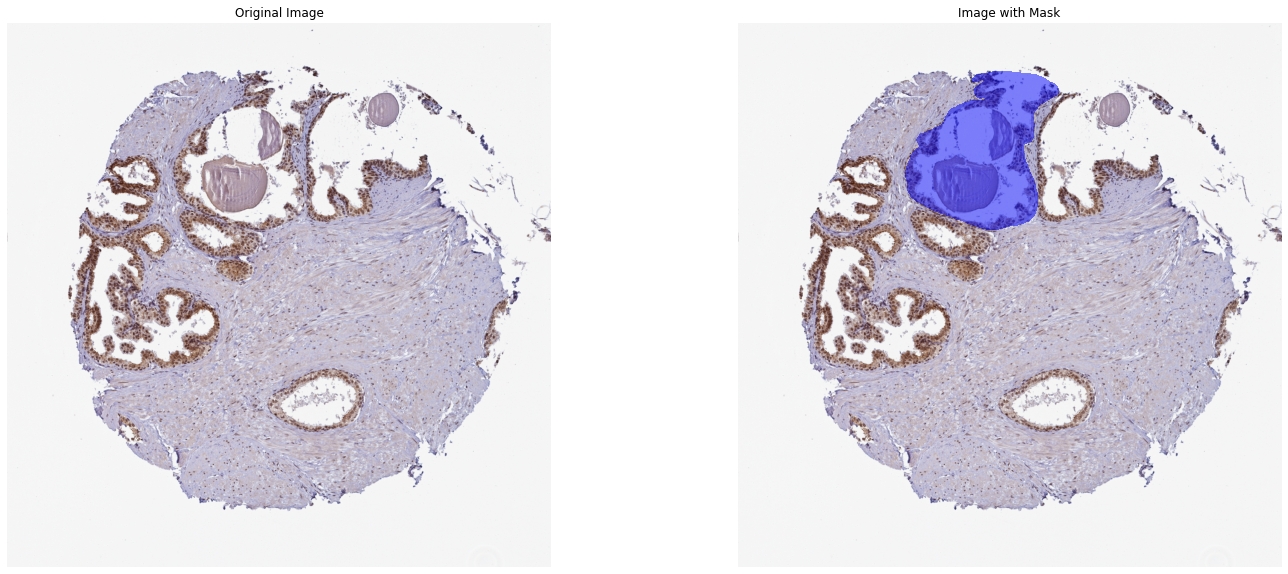

In [ ]:
def read_tiff(image_path):
    image = io.imread(image_path)
    return image

# Random idx
random_image = 4 #np.random.randint(0,len(train_df))
# Get image ID
img_id = list(gt.imgs)[random_image]
# Read image
np_image = read_tiff(os.path.join(IMAGE_DIR, gt.imgs[img_id]["file_name"]))
cv2.imwrite('img.jpg', np_image)
img = cv2.imread("img.jpg")

for ann_id in gt.getAnnIds(imgIds = [img_id]):
    ann_item = gt.anns[ann_id]
    mask = mask_util.decode(ann_item["segmentation"])
    
plot_original_mask(img, mask, alpha=0.5)